# Multi-channel PolyConvNet

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Load dataset
data = 'C' # ****** specify dataset (A / B / C / D) ******
dataset = pd.read_csv(f'./data/data_{data}.csv')
dataset_name='dataSet'+data

In [2]:
from keras import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Flatten, Concatenate, Input

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [16]:
#load kernels
kernel_matrix=[]
kernels = open(f'./features/{dataset_name}.kern').readlines()
for i in range(len(kernels)):
    kernel = [float(i) for i in kernels[i].strip().split()]
    kernel_matrix.append(kernel)
    
#load PC1-4
PC = pd.read_csv(f'./features/dataset{data}_principal_component_analysis.csv').iloc[:,1:5]

#load data
window_size = 2 # ****** specify window size ******

n_channel = 2**window_size

X = np.loadtxt(f"./features/sliding_window_{window_size}_dataset_{data}.txt")
X = X.reshape(X.shape[0], X.shape[1] // n_channel , n_channel)
interaction_param, y = dataset['interaction_parameter'], dataset['lamellar_period']

In [14]:
# train / test split
train_idx = np.random.choice(range(len(X)), size=int(0.8*(len(X))), replace=False)
X_train = X[train_idx]
y_train = np.array([y[i] for i in train_idx])

test_idx = list(set(range(len(X)))-set(train_idx))
X_test = X[test_idx]
y_test = np.array([y[i] for i in test_idx])

# auxInput
interaction_kernel_train = np.array([[interaction_param[i]]+kernel_matrix[i]+list(PC.iloc[i,:]) for i in train_idx])
interaction_kernel_test = np.array([[interaction_param[i]]+kernel_matrix[i]+list(PC.iloc[i,:]) for i in test_idx])

In [28]:
input_b = Input(shape=(46))

input = Input(shape =(32-window_size,n_channel)) 

x = Conv1D(32-window_size, 2, activation="relu", input_shape=(32-window_size,n_channel))(input)
x = Flatten()(x)

x = Concatenate()([x,input_b])
x = Flatten()(x)

x = Dense(units = 300, activation ='relu')(x)
x = Dense(units = 110, activation ='relu')(x)

regression = Dense(units = 1, activation='relu', name='regression')(x)

model = Model(inputs=[input,input_b], outputs=regression)

model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30, 4)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 29, 30)       270         ['input_5[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 870)          0           ['conv1d_1[0][0]']               
                                                                                                  
 input_4 (InputLayer)           [(None, 46)]         0           []                               
                                                                                            

/lus/theta-fs0/software/thetagpu/conda/2021-11-30/mconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
# model training
epochs = 500
history = model.fit([X_train, interaction_kernel_train], y_train, batch_size=12,epochs=epochs, verbose=1)

Epoch 1/500
52/52 [==============================] - 0s 1ms/step - loss: 28.7268
Epoch 2/500
52/52 [==============================] - 0s 1ms/step - loss: 0.2792
Epoch 3/500
52/52 [==============================] - 0s 1ms/step - loss: 0.1185
Epoch 4/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0932
Epoch 5/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0755
Epoch 6/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 7/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0716
Epoch 8/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0740
Epoch 9/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0562
Epoch 10/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0587
Epoch 11/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 12/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 13/500
52/52 [================

52/52 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 203/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 204/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 205/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0319
Epoch 206/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 207/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 208/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0327
Epoch 209/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0195
Epoch 210/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 211/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0299
Epoch 212/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0769
Epoch 213/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 214/500
52/52 [=========

52/52 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 303/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 304/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 305/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 306/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 307/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 308/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 309/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 310/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 311/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 312/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 313/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0176
Epoch 314/500
52/52 [=========

52/52 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 403/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 404/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 405/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 406/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 407/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 408/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 409/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 410/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 411/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 412/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 413/500
52/52 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 414/500
52/52 [=========

In [30]:
# making prediction
ypred_test = model.predict([X_test, interaction_kernel_test])
model_mse = mean_squared_error(y_test, ypred_test)
print("MSE: %.4f" % model_mse)

MSE: 0.0631


In [31]:
# calc R2
correlation_matrix = np.corrcoef(ypred_test.flatten(), y_test)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

INFO:tensorflow:Assets written to: multi_channel_polycovnet_C/assets


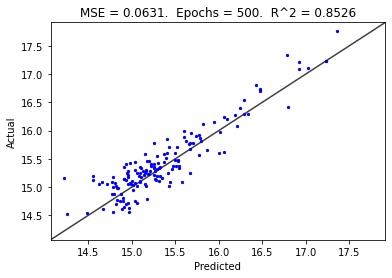

In [32]:
# plot result
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

plt.title(f'MSE = {model_mse:.4f}.  Epochs = {epochs}.  R^2 = {r_squared:.4f}') # MSE
plt.scatter(ypred_test, y_test, s=5, color="blue") # x_axis, y_axis, ...
plt.xlabel("Predicted")
plt.ylabel("Actual")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.savefig(f'./predictions/pred_{data}')

#save model
model.save(f"./models/multi_channel_polycovnet_{data}")